# About this notebook

This notebook is based on Coursera's course "Machine learning" by Prof. Andrew Ng from Stanford University. In this course, all codes are written in Octave or Matlab. This notebook provides the Python version of the codes.

This notebook is based on the Exerxise 7. Key words are as follows:
- K-means clustering
- Random initialization
- Image compression
- Principal component analysis (PCA)
- Dimensionality reduction
- Covariance matrix
- Singular value decomposition (SVD)

# K-means clustering

## Data preparation

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import linalg
import collections
import requests

path=os.getcwd()
datpath1=path + '/ex7data1.mat'
datpath2=path + '/ex7data2.mat'

#Getting data
dat1 = loadmat(datpath1) 
dat2 = loadmat(datpath2) 

#Showing keys
print(dat1.keys())
print(dat2.keys())

#Defining data
X1=dat1['X']
X2=dat2['X']

# Shapes of data
print("\nData size (X1): {}".format(X1.shape))
print("Data size (X2): {}".format(X2.shape))

dict_keys(['__header__', '__version__', '__globals__', 'X'])
dict_keys(['__header__', '__version__', '__globals__', 'X'])

Data size (X1): (50, 2)
Data size (X2): (300, 2)


## Data visualization

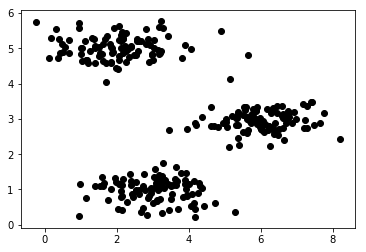

In [6]:
plt.scatter(X2[:,0],X2[:,1],color='black')
plt.show()

## Finding closest centroids

In the next cell, the function <strong>findClosestCentroids</strong> will be defined. This function requires two inputs:
- Xf: Input data, which is m x n matrix.
- cent_f: Initial centroids. K x n matrix. 

The input data <strong>Xf</strong> (m x n data) are seperated into K groups, where the integer K is the number of clusters. This function returns an m-dimensional vector whose values are integers and range from 0 to K-1. The integer value shows which class the i-th data of Xf belongs to, where i is the integer between 0 and m-1.

The procedure is as follows:  
1. Calculate the Euclidean squared distance between the i-th data and each centroid
$$
    d_{ik}=|x_{i}-c_{k}|^{2},
$$
where k is the integer that stands for a class k. 
2. Find the integer k that gives the smallest d<sub>ik</sub>.  
3. Return the list of integers.

In [7]:
def findClosestCentroids(Xf,cent_f):
    num_cluster_f=cent_f.shape[0] # Number of classes
    mf=Xf.shape[0]  # Number of datasets
    idx_f=np.zeros(mf)   # Initializing indices (labels for classes) 
    
    for i in range(mf):
        distance_sq_f=np.zeros(num_cluster_f) 

        for j in range(num_cluster_f):
            diff_f=Xf[i]-cent_f[j] # Difference between the given data and specific centroid.
            distance_sq_f[j] = np.dot(diff_f,diff_f.T)  # Squared distance
            
        idx_f[i] = np.argmin(distance_sq_f) # Assignment of a class to each data based on the squared distance
    
    return idx_f  # Indices (classes)

In [8]:
initial_centroids = np.array([[3,3],[6,2],[8,5]])
idx=findClosestCentroids(X2,initial_centroids) 

print("Initial centroids are \n{}\n".format(initial_centroids))
print("The first 3 labels for the given data are \n{}".format(idx[:3]))
print("(Expected labels are 0, 2, 1)")

Initial centroids are 
[[3 3]
 [6 2]
 [8 5]]

The first 3 labels for the given data are 
[0. 2. 1.]
(Expected labels are 0, 2, 1)


Data will be seperated into 3 groups using the closest centroid and visualized.

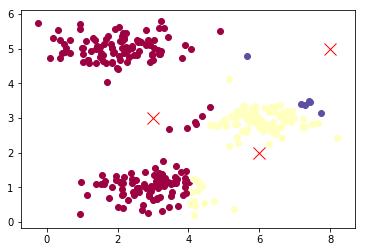

In [9]:
num_cluster = initial_centroids.shape[0]  # 3
color_list = plt.cm.Spectral(np.linspace(0, 1,num_cluster))  # Color list 

#Data visualization based on the classes
for j in range(X2.shape[0]):    
    for i in range(num_cluster):
        if idx[j]==i:
            plt.scatter(X2[j,0],X2[j,1],color=color_list[i])

# Visualization of centroids
for j in range(num_cluster):
    plt.plot(initial_centroids[j,0],initial_centroids[j,1],marker='x',color='red',markersize=12)

plt.show()

## Computing centroid means

The function <strong>computeCentroids</strong> requires 3 inputs:
- Xf: Input data. m x n.
- idx_f: Indices (labels for classes) 
- cent_f: Initial centroids   
Using these information, you can get new centroids.  
  
k-th centroid is calculated using this equation:
$$
    \mu_{k} = \frac{1}{N_{k}}\sum_{i=1}^{N_{k}}x_i,
$$
where N<sub>k</sub> is the number of elements that belong to the class k.  
   
If no data are classified as the class k, only the initial centroid for the k-th group will be returned. 

In [10]:
def computeCentroids(Xf, idx_f,cent_f):   
    #Xf: data
    #idx_f: indices
    #cent_f: initial centroids
    
    mf=Xf.shape[0]   # Number of data
    nf=Xf.shape[1]   # Dimension
    num_cluster_f=cent_f.shape[0] # Number of clusters

    count_f=collections.Counter(idx_f)  # Counting numbers of elements in all classes
    
    mu_f=np.zeros((num_cluster_f,nf)) # Initialization of new centroids

    for k in range(num_cluster_f):
        if count_f[k]==0: # If no elements are assigned to a specific class, an initial centroid is returned. 
            mu_f[k,:]=cent_f[k,:] 
            
    #Calculation of centroids
    for i in range(mf):   
        for j in range(num_cluster_f):
                if idx_f[i] == j:                     
                    mu_f[j,:] = Xf[i,:]/count_f[j] + mu_f[j,:]
    return mu_f

In [11]:
print("Centroids computed after initial finding of closest centroids: \n{}".format(computeCentroids(X2,idx,initial_centroids)))

print("Expected centroids:")
print("2.428301, 3.157924")
print("5.813503, 2.633656")
print("7.119387 3.616684")

Centroids computed after initial finding of closest centroids: 
[[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]
Expected centroids:
2.428301, 3.157924
5.813503, 2.633656
7.119387 3.616684


## K-means clustering on examples

In [12]:
def runKmeans(Xf, init_cent_f, num_iter_f):

    num_cluster_f = init_cent_f.shape[0] #number of clusters
    dim_f=Xf.shape[1] # dimension
        
    progress_Kmeans=np.zeros((num_iter_f+1, dim_f *num_cluster_f)) #history of the calculation
    ret=np.zeros(( num_cluster_f, dim_f )) #final coordinate

    #Iteration 
    for i in range(num_iter_f):
        if i==0:
            progress_Kmeans[0,:]=init_cent_f.flatten()
            
        idx_f = findClosestCentroids(Xf,init_cent_f) #Getting indices
        mu_f = computeCentroids(Xf, idx_f,init_cent_f) #Calculating centroids

        if dim_f==2: # If the dimension of the data is 2, the data will be visualized 
            color_list = plt.cm.Spectral(np.linspace(0, 1,num_cluster_f)) # Color list

            for j in range(Xf.shape[0]):    
                for k in range(num_cluster_f):
                    if idx_f[j]==k:  #Visualization of data that belong to a class k.
                        plt.scatter(Xf[j,0],Xf[j,1],color=color_list[k])

        init_cent_f=mu_f 
        progress_Kmeans[i+1,:] = init_cent_f.flatten()  #History       
        
    FinCoord_f=progress_Kmeans[num_iter_f]  # Final centroids   
    
    for l in range(num_cluster_f):        
        if dim_f==2: # The progress of the calculation will be visualized if the data is 2-dimensional
            plt.plot(progress_Kmeans[:,2*l],progress_Kmeans[:,2*l+1],marker='x',color='black')            
        
        ret[l]=FinCoord_f[dim_f*l:dim_f*(l+1)]  # Reshaping the final centroids

    return ret #Final coordinates for the centroids

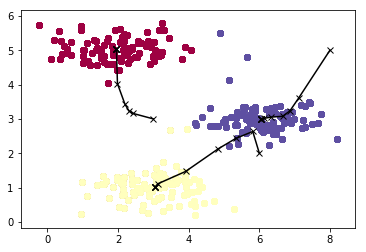

In [13]:
num_iter=10 # Number of iterations
initial_centroids = np.array([[3,3],[6,2],[8,5]]) 

FinCoord=runKmeans(X2, initial_centroids, num_iter)
plt.show()

In [14]:
print("After %d iterations, the centroids are:"%num_iter)
print(FinCoord)

After 10 iterations, the centroids are:
[[1.95399466 5.02557006]
 [3.04367119 1.01541041]
 [6.03366736 3.00052511]]


## Random initialization

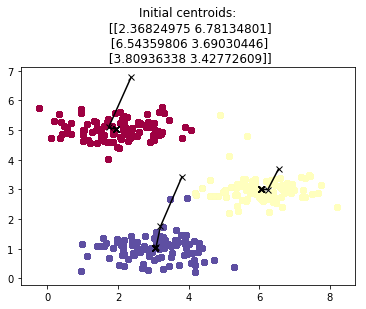

In [15]:
import random 

num_iter=10 # Number of iterations

rand_init_centroids = np.random.uniform(0,9, (3,2)) # Random initialization
plt.title("Initial centroids:\n {}".format(rand_init_centroids))
FinCoord=runKmeans(X2, rand_init_centroids, num_iter) 

plt.show()

In [16]:
print("After %d iterations, the centroids are:"%num_iter)
print(FinCoord)

After 10 iterations, the centroids are:
[[1.95399466 5.02557006]
 [6.03366736 3.00052511]
 [3.04367119 1.01541041]]


## scikit learn

K-means clustering was implemented using numpy library in the previous sections. In this section, scikit learn will be used to do the same thing.

In [17]:
from sklearn.cluster import KMeans

num_cluster=3 # Number of clusters

#Number of times the k-means algorithm will be run with different centroid seeds
num_k=100

k_means = KMeans(init="k-means++", n_clusters=num_cluster, n_init=num_k)
k_means.fit(X2)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

print('Determined centroids:\n', k_means_cluster_centers)

Determined centroids:
 [[6.03366736 3.00052511]
 [1.95399466 5.02557006]
 [3.04367119 1.01541041]]


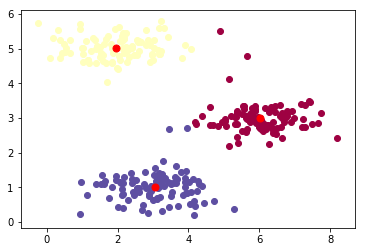

In [18]:
color_list = plt.cm.Spectral(np.linspace(0, 1,num_cluster))

# Visualization of the classification
for j in range(X2.shape[0]):
    coord_dat= np.array([X2[j,0],X2[j,1]]).reshape(1,2)
    
    for i in range(num_cluster):
        if k_means_labels[j]==i:
            plt.scatter(X2[j,0],X2[j,1],color=color_list[i])
            
# Visualization of centroids
for j in range(num_cluster):
    plt.plot(k_means_cluster_centers[j,0],k_means_cluster_centers[j,1],marker='o',color='red',markersize=7)

# Image compression using K-means clustering

## Numpy

### K means clustring for the same picture

In this part, K-means clustering will be applied to image compression. The data presented here is 128 x 128 image. Each pixel is represented as three 8-bit unsigned integers ranging from 0 to 255 that specify the red, green, and blue intensity values. Since the image that will be studied here contains thousands of colors, it is nice to reduce the number of colors so that we can handle it easily.

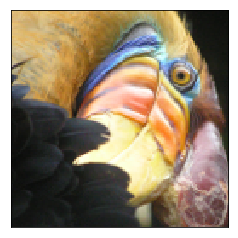

In [19]:
import imageio

path=os.getcwd()
datpath=path + '/bird_small.png'

img = imageio.imread(datpath)

plt.imshow(img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

In [20]:
print("Image size: {}".format(img.shape))

Image size: (128, 128, 3)


In [21]:
m_img=img.shape[0]

for j in range(m_img):
    if j==0:
        r_vec=img[:,0,0]
        g_vec=img[:,0,1]
        b_vec=img[:,0,2]

    else:
        r_vec=np.concatenate([r_vec,img[:,j,0]])
        b_vec=np.concatenate([b_vec,img[:,j,1]])
        g_vec=np.concatenate([g_vec,img[:,j,2]])
        
reshaped_img=np.concatenate([r_vec.reshape(-1,1), g_vec.reshape(-1,1),b_vec.reshape(-1,1) ], 1) 
reshaped_img=reshaped_img/255 # All values are normalized and range from 0 to 1

print("The reshaped image matrix has the size of {}".format(reshaped_img.shape))

The reshaped image matrix has the size of (16384, 3)


In [22]:
num_iter=10 # number of iterations to get centroids
num_cluster=16 # number of classes

initial_centroids= np.random.uniform(0,1, (num_cluster,3))  # random initialization

FinCoord=runKmeans(reshaped_img, initial_centroids, num_iter) #Getting final centroids
print("Determined centroids: \n{}".format(FinCoord)) #Showing the results

idx=findClosestCentroids(reshaped_img,FinCoord) # Assigning indices

Determined centroids: 
[[0.33494464 0.2338287  0.27526102]
 [0.8176121  0.78538151 0.7813646 ]
 [0.50142415 0.80809082 0.62106639]
 [0.1203922  0.7124843  0.02227895]
 [0.97967979 0.75849203 0.92290873]
 [0.10823411 0.10495923 0.11411689]
 [0.5535878  0.42089466 0.46524795]
 [0.23905831 0.74462678 0.86733907]
 [0.71187127 0.60722506 0.62662511]
 [0.62051851 0.20813885 0.45317136]
 [0.89341295 0.8861533  0.054906  ]
 [0.05740107 0.44528776 0.99367053]
 [0.74439635 0.41241721 0.6285363 ]
 [0.86032648 0.28256158 0.59436299]
 [0.34464229 0.49257022 0.38493906]
 [0.89518311 0.49182948 0.75032445]]


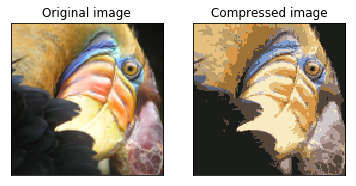

In [23]:
final_img=np.zeros(reshaped_img.shape)  # Initialization

for j in range(reshaped_img.shape[0]):
    final_img[j]=FinCoord[int(idx[j])]

#Showing an original image
plt.subplot(1,2,1)
original_img=reshaped_img[:, [0, 2,1]].reshape((128,128,3))
original_img=np.fliplr(np.rot90(original_img, k=-1, axes=(0, 1)))
plt.imshow(original_img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Original image")

# Showing a compressed image
plt.subplot(1,2,2)
final_img=final_img[:, [0, 2,1]].reshape((128,128,3))
final_img=np.fliplr(np.rot90(final_img, k=-1, axes=(0, 1)))
plt.imshow(final_img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Compressed image")

plt.show()

### Test for other pictures

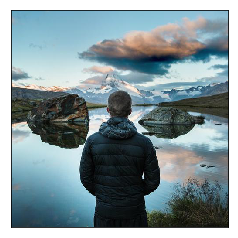

In [24]:
name='test_picture.png'
pic = requests.get('https://picsum.photos/500/500/?random')

with open(name,'wb') as pic_file:
    pic_file.write(pic.content)
    
path=os.getcwd()
datpath=path + '/test_picture.png'

img = imageio.imread(datpath)

plt.imshow(img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

In [25]:
print("Image size: {}".format(img.shape))

Image size: (500, 500, 3)


In [26]:
m_img=img.shape[0]

for j in range(m_img):
    if j==0:
        r_vec=img[:,0,0]
        g_vec=img[:,0,1]
        b_vec=img[:,0,2]

    else:
        r_vec=np.concatenate([r_vec,img[:,j,0]])
        b_vec=np.concatenate([b_vec,img[:,j,1]])
        g_vec=np.concatenate([g_vec,img[:,j,2]])
        
reshaped_img=np.concatenate([r_vec.reshape(-1,1), g_vec.reshape(-1,1),b_vec.reshape(-1,1) ], 1) 
reshaped_img=reshaped_img/255 # All values are normalized and range from 0 to 1

print("The reshaped image matrix has the size of {}".format(reshaped_img.shape))

The reshaped image matrix has the size of (250000, 3)


In [27]:
num_iter=10 # number of iterations to get centroids
num_cluster=16 # number of classes

initial_centroids= np.random.uniform(0,1, (num_cluster,3))  # random initialization

FinCoord=runKmeans(reshaped_img, initial_centroids, num_iter) #Getting final centroids
print("Determined centroids: \n{}".format(FinCoord)) #Showing the results

idx=findClosestCentroids(reshaped_img,FinCoord) # Assigning indices

Determined centroids: 
[[0.50083189 0.7697302  0.69249949]
 [0.19386063 0.1131077  0.7940833 ]
 [0.27350879 0.50241604 0.43729348]
 [0.48255248 0.56432242 0.03522816]
 [0.42961023 0.50695648 0.48502664]
 [0.6053592  0.8313601  0.77249382]
 [0.2078567  0.35682514 0.31685979]
 [0.79482146 0.74123518 0.76229337]
 [0.42240579 0.64414115 0.58037121]
 [0.6566204  0.16658792 0.76912855]
 [0.18217537 0.19680241 0.21332853]
 [0.81138885 0.89580557 0.88885024]
 [0.45957185 0.35746898 0.40148935]
 [0.06767084 0.08920984 0.09075778]
 [0.66782753 0.50282414 0.56116276]
 [0.65184443 0.66342887 0.65779463]]


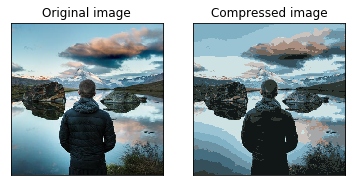

In [28]:
final_img=np.zeros(reshaped_img.shape)  # Initialization

for j in range(reshaped_img.shape[0]):
    final_img[j]=FinCoord[int(idx[j])]

#Showing an original image
plt.subplot(1,2,1)
original_img=reshaped_img[:, [0, 2,1]].reshape((500,500,3))
original_img=np.fliplr(np.rot90(original_img, k=-1, axes=(0, 1)))
plt.imshow(original_img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Original image")

# Showing a compressed image
plt.subplot(1,2,2)
final_img=final_img[:, [0, 2,1]].reshape((500,500,3))
final_img=np.fliplr(np.rot90(final_img, k=-1, axes=(0, 1)))
plt.imshow(final_img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Compressed image")

plt.show()

## scikit learn

### K means clustring for the sample picture

In [29]:
path=os.getcwd()
datpath=path + '/bird_small.png'

img = imageio.imread(datpath)

m_img=img.shape[0]

for j in range(m_img):
    if j==0:
        r_vec=img[:,0,0]
        g_vec=img[:,0,1]
        b_vec=img[:,0,2]

    else:
        r_vec=np.concatenate([r_vec,img[:,j,0]])
        b_vec=np.concatenate([b_vec,img[:,j,1]])
        g_vec=np.concatenate([g_vec,img[:,j,2]])
        
reshaped_img=np.concatenate([r_vec.reshape(-1,1), g_vec.reshape(-1,1),b_vec.reshape(-1,1) ], 1) 
reshaped_img=reshaped_img/255 # All values are normalized and range from 0 to 1

In [30]:
num_cluster=16 # Number of clusters

#Number of times the k-means algorithm will be run with different centroid seeds
num_k=10

k_means = KMeans(init="k-means++", n_clusters=num_cluster, n_init=num_k)
k_means.fit(reshaped_img)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

print('Determined centroids:\n', k_means_cluster_centers)

Determined centroids:
 [[0.64339469 0.20898443 0.46761917]
 [0.08545014 0.08251782 0.09238952]
 [0.96330393 0.63250579 0.85932979]
 [0.70299478 0.56651181 0.62634074]
 [0.16985604 0.16020186 0.16905663]
 [0.44807245 0.18499501 0.31941952]
 [0.97654559 0.81792207 0.94581592]
 [0.91791349 0.25224595 0.57090046]
 [0.28369909 0.26822491 0.26454573]
 [0.75670959 0.34077755 0.60596249]
 [0.56956863 0.86848627 0.72134902]
 [0.82786175 0.73737685 0.73707519]
 [0.46267166 0.35463024 0.39041884]
 [0.58826185 0.44987385 0.50206701]
 [0.38790123 0.64822077 0.45885258]
 [0.86920249 0.45562311 0.71724877]]


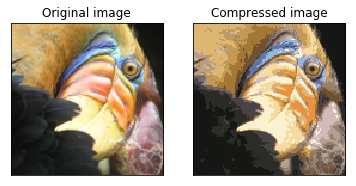

In [31]:
reduced_img=np.zeros((reshaped_img.shape))

for j in range(reduced_img.shape[0]):
    reduced_img[j]= k_means_cluster_centers[k_means_labels[j]]    
    
plt.subplot(1,2,1)
plt.imshow(img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Original image")

plt.subplot(1,2,2)
reduced_img=reduced_img[:, [0, 2,1]].reshape((128,128,3))
reduced_img=np.fliplr(np.rot90(reduced_img, k=-1, axes=(0, 1)))
plt.imshow(reduced_img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Compressed image")

plt.show()

### Test for other pictures

In [32]:
name='test_picture.png'
pic = requests.get('https://picsum.photos/500/500/?random')

with open(name,'wb') as pic_file:
    pic_file.write(pic.content)

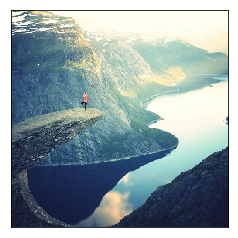

In [33]:
path=os.getcwd()
datpath=path + '/test_picture.png'

img = imageio.imread(datpath)

plt.imshow(img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

In [34]:
print("Image size: {}".format(img.shape))

Image size: (500, 500, 3)


In [35]:
m_img=img.shape[0]

for j in range(m_img):
    if j==0:
        r_vec=img[:,0,0]
        g_vec=img[:,0,1]
        b_vec=img[:,0,2]

    else:
        r_vec=np.concatenate([r_vec,img[:,j,0]])
        b_vec=np.concatenate([b_vec,img[:,j,1]])
        g_vec=np.concatenate([g_vec,img[:,j,2]])
        
reshaped_img=np.concatenate([r_vec.reshape(-1,1), g_vec.reshape(-1,1),b_vec.reshape(-1,1) ], 1)
reshaped_img=reshaped_img/255 # The value ranges from 0 to 1

print("The reshaped image matrix has the size of {}".format(reshaped_img.shape))

The reshaped image matrix has the size of (250000, 3)


In [36]:
num_cluster=16 # Number of classes

#Number of times the k-means algorithm will be run with different centroid seeds
num_k=10

k_means = KMeans(init="k-means++", n_clusters=num_cluster, n_init=num_k)
k_means.fit(reshaped_img)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

print('Determined centroids:\n', k_means_cluster_centers)

Determined centroids:
 [[0.09061491 0.22348502 0.12179224]
 [0.71679606 0.73340951 0.80626528]
 [0.36546764 0.56186247 0.51444356]
 [0.99241765 0.9285493  0.99205041]
 [0.21319664 0.43937927 0.33748089]
 [0.44829143 0.6526032  0.63223717]
 [0.87718368 0.7036643  0.84440651]
 [0.11337331 0.29215407 0.17050193]
 [0.28045167 0.49790127 0.42354323]
 [0.73013259 0.60646648 0.71132325]
 [0.94524641 0.83625836 0.93598618]
 [0.59049359 0.69591923 0.73020339]
 [0.79676106 0.8263034  0.88983924]
 [0.54472652 0.5598558  0.60483398]
 [0.15391378 0.36858736 0.24725673]
 [0.64494724 0.7983839  0.83193665]]


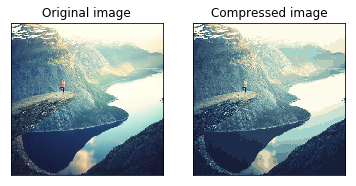

In [37]:
reduced_img=np.zeros((reshaped_img.shape))

for j in range(reduced_img.shape[0]):
    reduced_img[j]= k_means_cluster_centers[k_means_labels[j]]    
    
# Original image
plt.subplot(1,2,1)
plt.imshow(img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Original image")

# Compressed image
plt.subplot(1,2,2)
reduced_img=reduced_img[:, [0, 2,1]].reshape((500,500,3))
reduced_img=np.fliplr(np.rot90(reduced_img, k=-1, axes=(0, 1)))
plt.imshow(reduced_img)
plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
plt.title("Compressed image")

plt.show()

# Principal component analysis (PCA)

In this part, principal component analysis (PCA) will be used to perform reduction of dimension. PCA is widely used in various fields, especially for feature extraction and dimensionality reduction. This technique aims to find the directions of maximum variance in high-dimensional data and projects it onto a new subspace with equal or fewer dimensions than the original one. The new subspace is spaned by orthogonal axes (principal components).

## Data visualization

In [38]:
print("Data shape: {}".format(X1.shape))

Data shape: (50, 2)


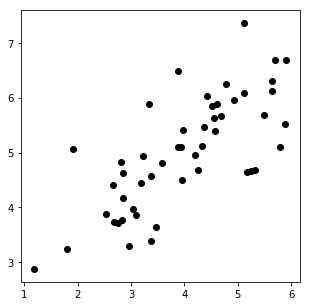

In [39]:
plt.figure(figsize=(5,5))
plt.scatter(X1[:,0],X1[:,1],color='black')
plt.show()

## Computing principal components using numpy

In [43]:
#Feature normalization
# Subtraction of mean and division by standard deviation
sc = StandardScaler()
X1norm=sc.fit_transform(X1)

#Compute covariance matrix
m=X1.shape[0]
sigma=np.matmul(X1norm.T,X1norm) / m  # nf x nf matrix    

#Eigenvalues and eigenvectors of the covariance matrix
eigen_vals, eigen_vecs = np.linalg.eig(sigma)

print("Eigenvalues: \n{}".format(eigen_vals))
print("\nEigenvectors:\n {}".format(eigen_vecs))

Eigenvalues: 
[1.73553038 0.26446962]

Eigenvectors:
 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


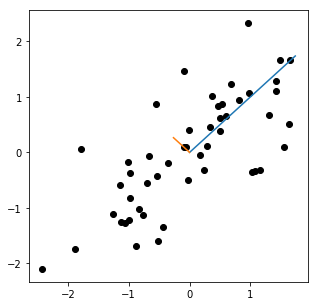

In [44]:
evec1=np.array([[0,0],[eigen_vals[0]*eigen_vecs[0,0]/np.abs(eigen_vecs[0,0]),eigen_vals[0]*eigen_vecs[1,0]/np.abs(eigen_vecs[1,0])]])
evec2=np.array([[0,0],[eigen_vals[1]*eigen_vecs[0,1]/np.abs(eigen_vecs[0,1]),eigen_vals[1]*eigen_vecs[1,1]/np.abs(eigen_vecs[1,1])]])

plt.figure(figsize=(5,5))
plt.scatter(X1norm[:,0],X1norm[:,1],color='black')
plt.plot(evec1[:,0],evec1[:,1])
plt.plot(evec2[:,0],evec2[:,1])
plt.show()

## Computing principal components using scikit learn

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Xtrans=pca.fit_transform(X1norm)
eigen_vecs=pca.components_ # 
eigen_vals=pca.explained_variance_

print("Eigenvectors: \n{}".format(eigen_vecs))
print("\nEigenvalues: \n{}". format(eigen_vals))

Eigenvectors: 
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]

Eigenvalues: 
[1.77094936 0.26986696]


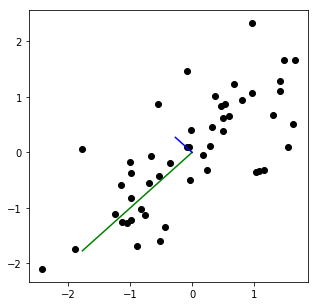

In [46]:
evec1=np.array([[0,0],[eigen_vals[0]*eigen_vecs[0,0]/np.abs(eigen_vecs[0,0]),eigen_vals[0]*eigen_vecs[0,1]/np.abs(eigen_vecs[0,1])]])
evec2=np.array([[0,0],[eigen_vals[1]*eigen_vecs[1,0]/np.abs(eigen_vecs[1,0]),eigen_vals[1]*eigen_vecs[1,1]/np.abs(eigen_vecs[1,1])]])

plt.figure(figsize=(5,5))
plt.scatter(X1norm[:,0],X1norm[:,1],color='black')
plt.plot(evec1[:,0],evec1[:,1],color='green')
plt.plot(evec2[:,0],evec2[:,1],color='blue')
plt.show()

## Singular value decomposition (SVD)

You can also use [singular value decomposition (SVD)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html) to do the same thing and project dataset onto principle axes. After implementing this method, a matrix is decomposed into two unitary matrices U and V and a 1-D array s.

Let us consider a covariance matrix &Sigma;, which is a square matrix in the present case. The covariance matrix &Sigma; (2 x 2 matrix) can be deconposed into 2x2 matrix U, 2-dimentional vector s, and 2x2 matrix V. If we define the new matrix S whose diagonal components are those of s as
$$
    S=
            \left[\begin{array}{c}
            s_0 & 0\\
            0 & s_1\\
        \end{array}\right] \quad,
$$
we can get
$$
    \Sigma = U S V
$$

In [47]:
cov_matrix = np.cov(X1norm.T)
U, s, V = linalg.svd(cov_matrix, full_matrices = True, compute_uv = True)

print("X1 shape: \n{}".format(X1.shape))
print("\nU=\n{}".format(U))
print("\ns=\n{}".format(s))
print("\nV=\n{}".format(V))

X1 shape: 
(50, 2)

U=
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]

s=
[1.77094936 0.26986696]

V=
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


As explained before, the covariance matrix can be reconstructed from U, S, and V. In the next cell, this will be checked.

In [48]:
S=np.diag(s)
recon_mat=np.dot(U,np.dot(S,V))
if np.allclose(recon_mat,cov_matrix)==True:
    print("It is verified that the matrices U, S, and V can reconstruct the covariance matrix.")
else:  
    print("Check your calculation.")

It is verified that the matrices U, S, and V can reconstruct the covariance matrix.


Next, the function <strong>projectData</strong> will be defined. A dataset X, the principal components U, and the disired number of dimensions to reduced to K should be given. Each example in X is projected onto the top K components in U.

In [49]:
def projectData(Xf,Uf,Kf):
    Ured=U[:,:Kf]
    zf=np.matmul(Xf,Ured)
    return zf

In [50]:
K=1
z=projectData(X1norm,U,K)

With the function <strong>projectData</strong>, the data can be projected onto the lower dimensional space. The function <strong>recoverData</strong> will be defined to recover the data by project them back onto the original high dimensional space.

In [51]:
def recoverData(zf, Uf, Kf):
    Ured_f = Uf[:,:K]
    Xrec_f = np.dot(zf,Ured_f.T)  
    return Xrec_f

In [52]:
Xrec=recoverData(z,U,K)

print("X1norm shape:\n{}".format(X1norm.shape))
print("\nz shape:\n{}".format(z.shape))
print("\nXrec shape:\n{}".format(Xrec.shape))

X1norm shape:
(50, 2)

z shape:
(50, 1)

Xrec shape:
(50, 2)


The projection result will be visualized.

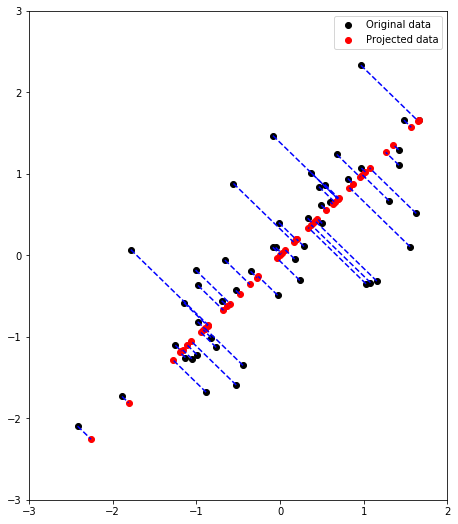

In [53]:
plt.figure(figsize=(7.5,9))
plt.scatter(X1norm[:,0],X1norm[:,1],color='black',label='Original data')
plt.scatter(Xrec[:,0],Xrec[:,1],color='red',label='Projected data')

for j in range(X1norm.shape[0]):
    projection_line=np.array([[X1norm[j,0],X1norm[j,1]],[Xrec[j,0],Xrec[j,1]]])
    plt.plot(projection_line[:,0],projection_line[:,1],color='blue',linestyle='dashed')

    
plt.xlim(-3 , 2)
plt.ylim(-3 , 3)
plt.legend()

plt.show()

# Application of PCA to face images

## Data visualization

The dataset <strong>ex7faces.mat</strong> contains a dataset X of face images, each 32 x 32 in grayscale. Each row of X corresponds to one face image. A row vector has the length of 1024 (= 32 x 32).

In [54]:
path=os.getcwd()
datpath=path + '/ex7faces.mat'

#Getting data
dat = loadmat(datpath) 

print(dat.keys())

X=dat['X']

print("Data shape:\n {}".format(X.shape))

dict_keys(['__header__', '__version__', '__globals__', 'X'])
Data shape:
 (5000, 1024)


In [55]:
def ConvertVectorToMatrix(Xf):
#convert (1 x nf*nf) vector into (nf x nf) matrix
    nf= int(np.sqrt(Xf.shape[0]))
    ret = np.zeros([nf,nf])
    
    for j in range(nf):
        n_int=nf*j
        n_fin=nf*(j+1)        

        ret[j]=Xf[n_int:n_fin]
    
    return ret

100 pictures will be randomly selected and visualized.

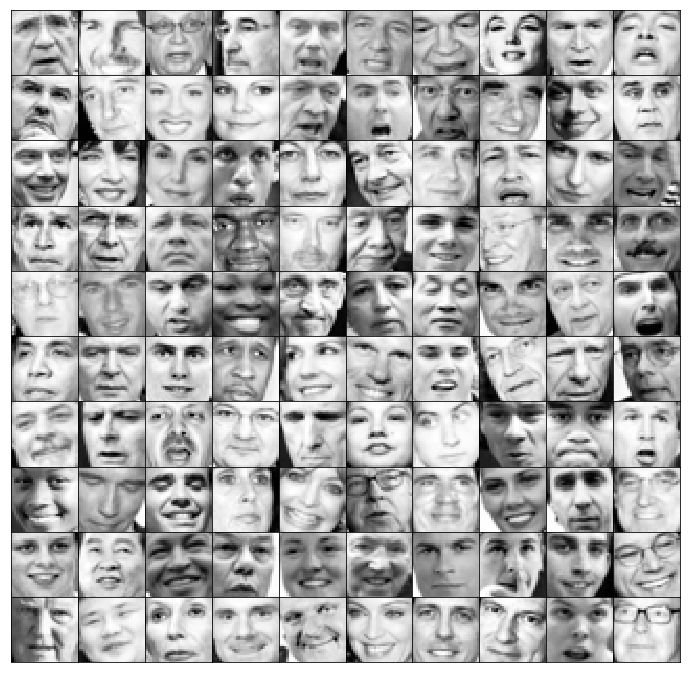

In [56]:
num_fig=100
m=X.shape[0]

plt.figure(figsize=(12,12))

for j in range(num_fig):
    plt.subplot(10,10, j+1)
    ran_num=random.randrange(0,m-1,1)

    plt.pcolormesh(np.rot90(ConvertVectorToMatrix(X[ran_num]),k=1,axes=(0,1)),cmap='Greys_r')

    plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## SVD method

In [57]:
# Feature normalization
sc = StandardScaler()
Xnorm=sc.fit_transform(X)

#Covariance matrix
cov_matrix = np.cov(Xnorm.T)

# SVD
U, s, V = linalg.svd(cov_matrix, full_matrices = True, compute_uv = True)

print("Data shape of X: {}".format(X.shape))
print("Data shape of U: {}".format(U.shape))
print("Data shape of s: {}".format(s.shape))
print("Data shape of V: {}".format(V.shape))

Data shape of X: (5000, 1024)
Data shape of U: (1024, 1024)
Data shape of s: (1024,)
Data shape of V: (1024, 1024)


Let us quickly check whether the covariance matrix can be reconstructed using U, S, and V.

In [58]:
S=np.diag(s)
recon_mat=np.dot(U,np.dot(S,V))
if np.allclose(recon_mat,cov_matrix)==True:
    print("It is verified that the matrices U, S, and V can reconstruct the covariance matrix.")
else:  
    print("Check your calculation.")

It is verified that the matrices U, S, and V can reconstruct the covariance matrix.


 The first 36 principal components that describe the largest variations (U[:,:36]) will be visualized.

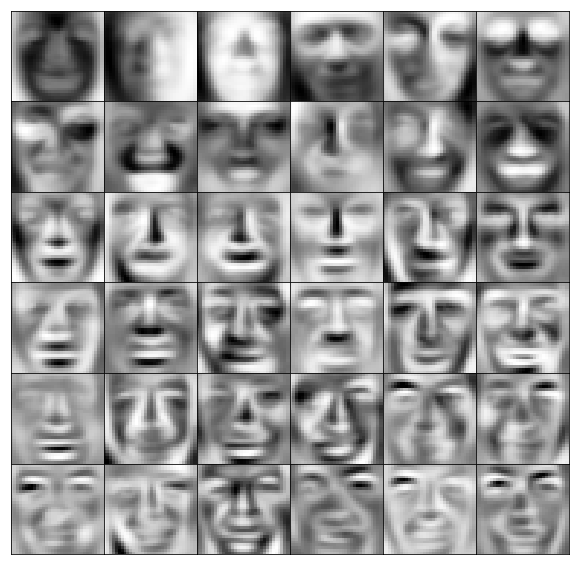

In [59]:
num_fig=36
plt.figure(figsize=(10,10))
U_visualization=U[:,:36].T 

for j in range(num_fig):
    plt.subplot(6,6, j+1)
    plt.pcolormesh(np.rot90(ConvertVectorToMatrix(U_visualization[j]),k=1,axes=(0,1)),cmap='Greys_r')
    plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

The principal components can be used to reduce the dimension of the face dataset. This procedure allows you to use your learning algorithm with a smaller input size. In the next cell, the original input size of 1024 dimensions will be reduced to 100 dimensions. You can see that fine details are lost in the reduced pictures.

In [60]:
K=100
z=projectData(Xnorm,U,K)
Xrec=recoverData(z, U, K)

print("Xnorm shape:\n{}".format(Xnorm.shape))
print("\nz shape:\n{}".format(z.shape))
print("\nXrec shape:\n{}".format(Xrec.shape))

Xnorm shape:
(5000, 1024)

z shape:
(5000, 100)

Xrec shape:
(5000, 1024)


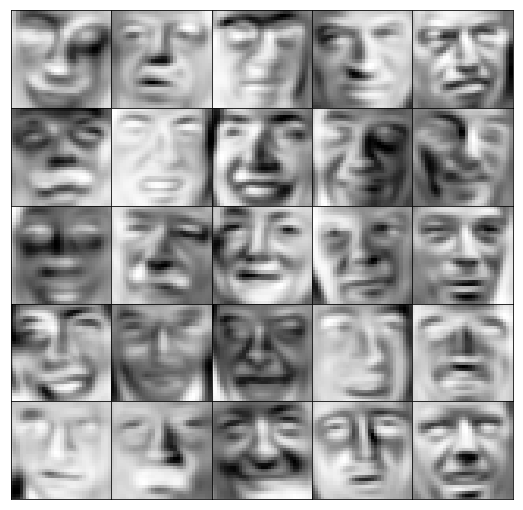

In [61]:
num_fig=25
mz=Xrec.shape[0]

plt.figure(figsize=(9,9))

for j in range(num_fig):
    plt.subplot(5,5, j+1)
    ran_num=random.randrange(0,mz-1,1)

    plt.pcolormesh(np.rot90(ConvertVectorToMatrix(Xrec[ran_num]),k=1,axes=(0,1)),cmap='Greys_r')

    plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# PCA for visualization

In the earlier K-means image compression exercise, the K-means algorithm was used in the 3-D RGB space. The colors of the image were grouped into 16 clusters. It is often useful to visualize such data. However, visualization of 3-dimensional (or higher) data is often cumbersome. Therefore, it is often desirable to display the data in 2D. PCA can be used to do this dimensionality reduction.

Data will be taken again, and some variables and arrays will be defined.

In [62]:
path=os.getcwd()
datpath=path + '/bird_small.png'

img = imageio.imread(datpath)

m_img=img.shape[0]

for j in range(m_img):
    if j==0:
        r_vec=img[:,0,0]
        g_vec=img[:,0,1]
        b_vec=img[:,0,2]

    else:
        r_vec=np.concatenate([r_vec,img[:,j,0]])
        b_vec=np.concatenate([b_vec,img[:,j,1]])
        g_vec=np.concatenate([g_vec,img[:,j,2]])
        
reshaped_img=np.concatenate([r_vec.reshape(-1,1), g_vec.reshape(-1,1),b_vec.reshape(-1,1) ], 1) 
reshaped_img=reshaped_img/255

K-means clustering will be implemented.

In [63]:
num_cluster=16 # Number of clusters

#Number of times the k-means algorithm will be run with different centroid seeds
num_k=10

k_means = KMeans(init="k-means++", n_clusters=num_cluster, n_init=num_k)
k_means.fit(reshaped_img)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

Feature normalization will be performed.

In [64]:
sc = StandardScaler()
img_norm=sc.fit_transform(reshaped_img)

SVD will be performed.

In [65]:
cov_matrix = np.cov(img_norm.T)

# SVD
U, s, V = linalg.svd(cov_matrix, full_matrices = True, compute_uv = True)

print("Data shape of img_norm: {}".format(img_norm.shape))
print("Data shape of cov_matrix: {}".format(cov_matrix.shape))
print("Data shape of U: {}".format(U.shape))
print("Data shape of s: {}".format(s.shape))
print("Data shape of V: {}".format(V.shape))

Data shape of img_norm: (16384, 3)
Data shape of cov_matrix: (3, 3)
Data shape of U: (3, 3)
Data shape of s: (3,)
Data shape of V: (3, 3)


Let us quickly check whether the covariance matrix can be reconstructed using U, S, and V.

In [66]:
S=np.diag(s)
recon_mat=np.dot(U,np.dot(S,V))
if np.allclose(recon_mat,cov_matrix)==True:
    print("It is verified that the matrices U, S, and V can reconstruct the covariance matrix.")
else:  
    print("Check your calculation.")

It is verified that the matrices U, S, and V can reconstruct the covariance matrix.


The 3-D data will be projected onto 2-D surface.

In [67]:
z=projectData(img_norm,U,2)

print("img_norm shape:\n{}".format(img_norm.shape))
print("\nz shape:\n{}".format(z.shape))

img_norm shape:
(16384, 3)

z shape:
(16384, 2)


The projected data will be visualized. The different colors show different clusters.

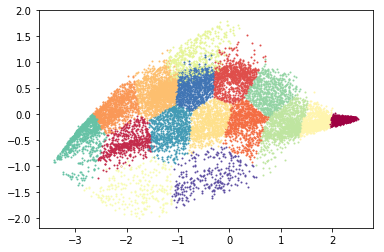

In [68]:
color_list = plt.cm.Spectral(np.linspace(0, 1,num_cluster))  # Color list 

for j in range(z.shape[0]):
    plt.scatter(z[j,0],z[j,1],color=color_list[k_means_labels[j]],s=1)